<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [1]:
#!pip install --upgrade --no-cache-dir gdown --quiet

In [2]:
import numpy as np
import random
import io
import pickle
import pandas as pd
import re # Regular Expressions (regex)

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils.np_utils import to_categorical
#2.7
#from tensorflow.keras.utils import pad_sequences
#2.1
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split


### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [3]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8
To: /content/clothing_ecommerce_reviews.csv
100%|██████████| 8.48M/8.48M [00:00<00:00, 124MB/s]


In [4]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [5]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


In [6]:
df_reviews['Review Text']

0        Absolutely wonderful - silky and sexy and comf...
1        Love this dress!  it's sooo pretty.  i happene...
2        I had such high hopes for this dress and reall...
3        I love, love, love this jumpsuit. it's fun, fl...
4        This shirt is very flattering to all due to th...
                               ...                        
23481    I was very happy to snag this dress at such a ...
23482    It reminds me of maternity clothes. soft, stre...
23483    This fit well, but the top was very see throug...
23484    I bought this dress for a wedding i have this ...
23485    This dress in a lovely platinum is feminine an...
Name: Review Text, Length: 22641, dtype: object

In [7]:
text = df_reviews['Review Text'].apply(lambda x: re.sub(r'\[[0-9]*\]', ' ', x))
text = text.apply(lambda x: re.sub(r'\s+', ' ', x))

text.head()

0    Absolutely wonderful - silky and sexy and comf...
1    Love this dress! it's sooo pretty. i happened ...
2    I had such high hopes for this dress and reall...
3    I love, love, love this jumpsuit. it's fun, fl...
4    This shirt is very flattering to all due to th...
Name: Review Text, dtype: object

4    12540
3     4908
2     2823
1     1549
0      821
Name: Rating, dtype: int64


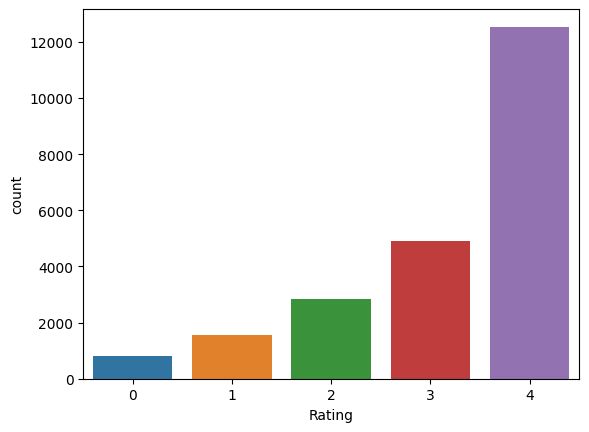

In [8]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase
print(df_reviews['Rating'].value_counts())

sns.countplot(x='Rating', data=df_reviews)
plt.show()

3    2823
2    2823
4    2823
1    1549
0     821
Name: Rating, dtype: int64


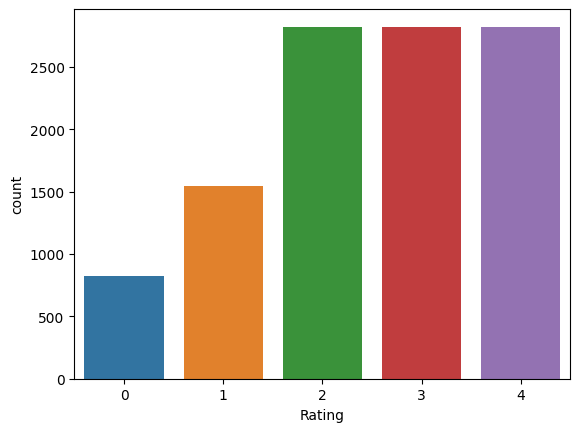

In [9]:
count_2 = df_reviews[df_reviews['Rating'] == 2].shape[0]
count_3 = df_reviews[df_reviews['Rating'] == 3].shape[0]
count_4 = df_reviews[df_reviews['Rating'] == 4].shape[0]

diff4 = count_4 - count_2
diff3 = count_3 - count_2

if diff3 > 0:
    df_reviews = df_reviews.drop(df_reviews[df_reviews['Rating'] == 3].sample(diff3).index)

if diff4 > 0:
    df_reviews = df_reviews.drop(df_reviews[df_reviews['Rating'] == 4].sample(diff4).index)

print(df_reviews['Rating'].value_counts())

sns.countplot(x='Rating', data=df_reviews)
plt.show()


In [10]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
text_sequences = df_reviews['Review Text'].values
text_sequences.shape

(10839,)

In [11]:
# Alumno: Cuantas reviews (rows) hay para evaluar?
len(text_sequences)
text_sequences

array(['Absolutely wonderful - silky and sexy and comfortable',
       'I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c',
       "I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!",
       ...,
       'It reminds me of maternity clothes. soft, stretchy, shiny material. cut is flattering and drapes nicely. i only found one button to close front... looked awkward. nice long sleeves.\nnot for me but maybe for others. just ok.',
       "This fit well, but the top was very

In [12]:
# Alumno: Concatenar todas las reviews para armar el corpus
corpus = ' '.join(text_sequences)

In [13]:
# Alumno: ¿Cuál es la longitud de ese corpus?
len(corpus)

3440423

In [14]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
tokens = text_to_word_sequence(corpus)

In [15]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras
tokens[:20]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'i',
 'had',
 'such',
 'high',
 'hopes',
 'for',
 'this',
 'dress',
 'and',
 'really',
 'wanted',
 'it',
 'to']

In [16]:
# Alumno: ¿Cuántos tokens/palabras hay?
len(tokens)

674690

In [17]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
num_words = 2000
vocab_size = num_words
tok = Tokenizer(num_words=2000) 
tok.fit_on_texts(tokens)

In [18]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
len(word_index)


10939

In [19]:
# Alumno: Convertir las palabras/tokens a números
sequences = tok.texts_to_sequences(text_sequences)

In [20]:
# Alumno: Determinar cual es la oración más larga
max(len(s) for s in sequences)

115

-----

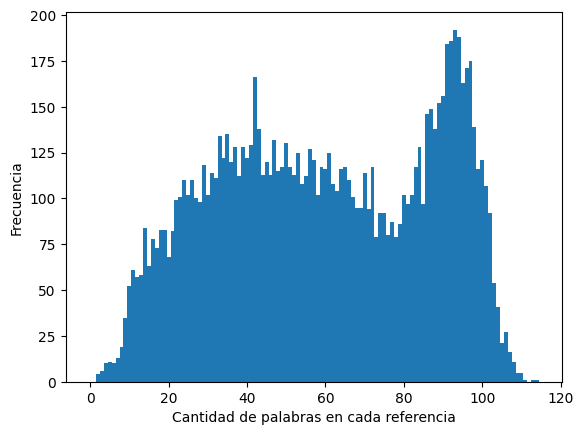

In [21]:
counts = [np.count_nonzero(subarr) for subarr in sequences]

new_arr = np.array(counts)

plt.hist(new_arr, bins=range(0, max(new_arr)+1), align='left')

plt.xlabel('Cantidad de palabras en cada referencia')
plt.ylabel('Frecuencia')

plt.show()

-------------

In [22]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
#from tensorflow.keras.utils import pad_sequences
maxlen = 115

X = pad_sequences(sequences, padding='post', maxlen=maxlen)
X

array([[ 291,  649, 1061, ...,    0,    0,    0],
       [   2,   54,  323, ...,    0,    0,    0],
       [   2,   27,   27, ...,    0,    0,    0],
       ...,
       [   4, 1918,   26, ...,    0,    0,    0],
       [   7,   28,   70, ...,    0,    0,    0],
       [   2,   88,    7, ...,    0,    0,    0]], dtype=int32)

In [23]:
# Alumno: Observar las dimensiones de la variable input
X.shape

(10839, 115)

In [24]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)
y = df_reviews['Rating'].values

from keras.utils import to_categorical
y = to_categorical(y, num_classes=5)
#y = (y - y.min()) / (y.max() - y.min())

print(y.shape)
#print(min(y))


(10839, 5)


In [25]:
# Alumno: Dividir los datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train[1]

array([ 451,   47,   41,  451,   80,    7,  170,   19,    6,   82,    1,
        125,    6,    5,  234,   13,   39,   24,  492,   21,  287,   10,
         33,  292,   13,  154,  216,    7,   19,  344,    3,   59,    1,
         25,    6,  262,    2,  243,    4,   22,   71,   59,   40,   92,
       1897,    1,  524,  169,    1,   84,    8,  193,    4,  262,   20,
        237,  287,    1,  131,  684,   13,   26,  133,   62,    4,  404,
          9,    1,  613,   59,    1,   84,   32,   70,   32,  535,  169,
          1,  180,   30, 1286,   42,  162,    4,  120,   24,    5,  641,
         10,   62,   33,   11,    3,    4,   60,  371,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int32)

In [26]:
# Alumno: determinar la dimensiones de entrada y salida
in_shape = X_train.shape[1] # max input sentence len
out_shape = 5 # binary classification
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 115 , out_shape 5


## Entrenar el modelo con Embeddings Fasttext + LSTM

In [27]:
!curl -L -o 'fasttext.pkl' 'https://drive.google.com/u/0/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa&export=download&confirm=t'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2746M  100 2746M    0     0   174M      0  0:00:15  0:00:15 --:--:--  203M


In [28]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    #PKL_PATH = 'C:/temp/fasttext.pkl'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [29]:
model_fasttext = FasttextEmbeddings()


El dataset ya se encuentra descargado
3    2823
2    2823
4    2823
1    1549
0     821
Name: Rating, dtype: int64


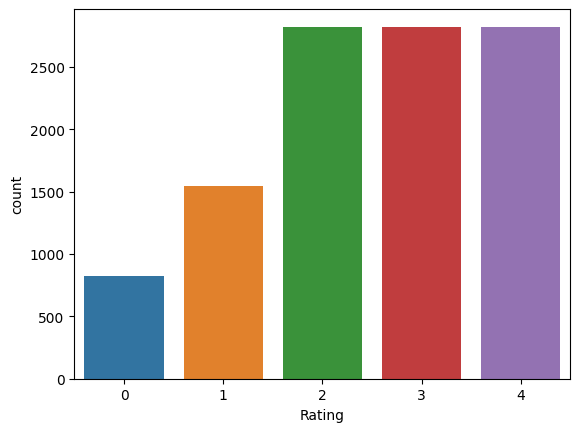

In [30]:
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")


df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()
#
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

##
count_2 = df_reviews[df_reviews['Rating'] == 2].shape[0]
count_3 = df_reviews[df_reviews['Rating'] == 3].shape[0]
count_4 = df_reviews[df_reviews['Rating'] == 4].shape[0]

diff4 = count_4 - count_2
diff3 = count_3 - count_2

if diff3 > 0:
    df_reviews = df_reviews.drop(df_reviews[df_reviews['Rating'] == 3].sample(diff3).index)

if diff4 > 0:
    df_reviews = df_reviews.drop(df_reviews[df_reviews['Rating'] == 4].sample(diff4).index)

print(df_reviews['Rating'].value_counts())

sns.countplot(x='Rating', data=df_reviews)
plt.show()

##
counts = df_reviews['Rating'].value_counts()


text_sequences = df_reviews['Review Text'].values
corpus = ' '.join(text_sequences)
##

tokens = text_to_word_sequence(corpus)

num_words = 2000
vocab_size = num_words
tok = Tokenizer(num_words=2000) 
tok.fit_on_texts(tokens)

word_index = tok.word_index

sequences = tok.texts_to_sequences(text_sequences)



In [31]:
maxlen = max(len(s) for s in sequences)

X2 = pad_sequences(sequences, padding='pre', maxlen=maxlen)
#X2 = (X2 - X2.min()) / (X2.max() - X2.min())

y2 = df_reviews['Rating'].values
#y2 = (y2 - y2.min()) / (y2.max() - y2.min())


#max(y)
y2 = to_categorical(y2, num_classes=5)

X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

 
in_shape = X_train.shape[1] # max input sentence len
out_shape = 5 # binary classification


In [32]:
#model_fasttext = FasttextEmbeddings()

print('preparing embedding matrix...')
embed_dim = 300 # fasttext
words_not_found = []

# word_index proviene del tokenizer


nb_words = min(num_words, len(word_index)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))

# word_index está ordenado de mayor a menor frecuencia de palabras
# las primeras que entren en el ciclo for serán las más frecuentes
# Atención! El tokenizador de Keras no tiene soporte para stop words
# las primeras palabras probablemente sean stopwords, para eliminarlas
# hay que procesar el word_index o bien elegir otra librería para preprocesamiento
# ¡ver clase 2! ;)
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = model_fasttext.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        # words que no estén en el índice de la matriz de embedding tendrán
        # como vector de embedding correspondiente todos ceros
        words_not_found.append(word)
        print(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 2


In [36]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.layers import Bidirectional

model3 = Sequential()
model3.add(Embedding(input_dim=vocab_size, 
                    output_dim=embed_dim, 
                    input_length=in_shape, 
                    weights=[embedding_matrix], 
                    trainable=False))

model3.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model3.add(Dropout(0.2))
model3.add(Bidirectional(LSTM(units=64)))
model3.add(Dense(units=128, activation='relu'))
model3.add(Dropout(rate=0.2))
model3.add(Dense(units=out_shape, activation='softmax'))

adam = Adam(learning_rate=0.001)
#adam = Adam(lr=0.001) 

model3.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


es = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=1, 
                   patience=3)


history = model3.fit(X_train, y_train,
                    epochs=100,
                    batch_size=2,
                    validation_data=(X_test, y_test),
                    callbacks=[es],
                    verbose=1)


Epoch 1/100
4336/4336 [==============================] - 103s 22ms/step - loss: 1.5311 - accuracy: 0.2801 - val_loss: 1.5198 - val_accuracy: 0.2781
Epoch 2/100
4336/4336 [==============================] - 90s 21ms/step - loss: 1.5160 - accuracy: 0.2940 - val_loss: 1.4950 - val_accuracy: 0.3169
Epoch 3/100
4336/4336 [==============================] - 90s 21ms/step - loss: 1.4690 - accuracy: 0.3391 - val_loss: 1.4497 - val_accuracy: 0.3450
Epoch 4/100
4336/4336 [==============================] - 89s 21ms/step - loss: 1.4273 - accuracy: 0.3634 - val_loss: 1.4054 - val_accuracy: 0.3713
Epoch 5/100
4336/4336 [==============================] - 89s 21ms/step - loss: 1.3882 - accuracy: 0.3793 - val_loss: 1.4642 - val_accuracy: 0.3312
Epoch 6/100
4336/4336 [==============================] - 90s 21ms/step - loss: 1.3556 - accuracy: 0.3908 - val_loss: 1.3880 - val_accuracy: 0.3842
Epoch 7/100
4336/4336 [==============================] - 89s 21ms/step - loss: 1.3284 - accuracy: 0.4145 - val_loss: 

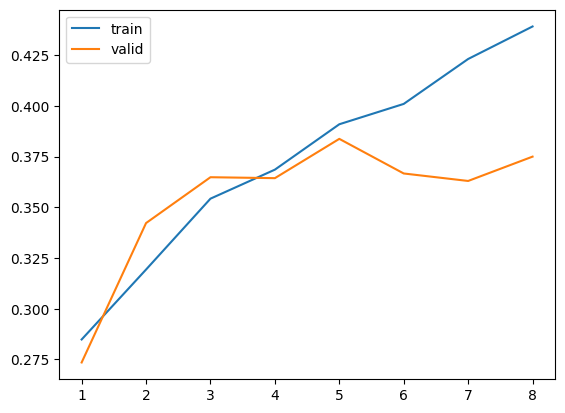

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(history.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history.history['val_accuracy'], label='valid')
plt.show()

---------